In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db
import warnings
warnings.filterwarnings('ignore')

In [6]:
ls /home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles

AF_L.trk             CCMid.trk  CST_R.trk   IFOF_L.trk
AF_R.trk             C_L.trk    F_L.trk     MCP.trk
CC_ForcepsMajor.trk  C_R.trk    F_R.trk     UF_L.trk
CC_ForcepsMinor.trk  CST_L.trk  IF0F_R.trk  UF_R.trk


In [7]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [8]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [9]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [13]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [14]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [15]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100

In [16]:
import imp  
imp.reload(bn)
streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,5).compute() 
data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


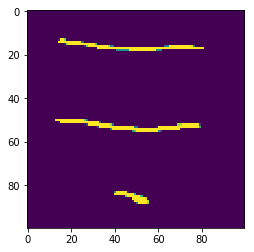

In [17]:
plt.imshow(streamlines_processed[5][1,:,:,0])

In [18]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels_train),
                                                 labels_train)

In [20]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test  = keras.utils.to_categorical(labels_test, num_classes)
labels_val  = keras.utils.to_categorical(labels_val, num_classes)

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [24]:
from IPython.display import SVG
from keras.utils import plot_model
#from vis_utils import plot_model
plot_model(model, to_file='model.png')

In [25]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [26]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list,
                     class_weight=class_weights)

Train on 921 samples, validate on 231 samples
Epoch 1/16
921/921 [==============================] - 5s 5ms/step - loss: 0.2808 - acc: 0.9218 - val_loss: 0.0242 - val_acc: 0.9913

Epoch 00001: val_acc improved from -inf to 0.99134, saving model to checkpoints/weights.best.hdf5
Epoch 2/16
921/921 [==============================] - 3s 3ms/step - loss: 0.0273 - acc: 0.9935 - val_loss: 0.0010 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.99134 to 1.00000, saving model to checkpoints/weights.best.hdf5
Epoch 3/16
921/921 [==============================] - 3s 3ms/step - loss: 6.0625e-04 - acc: 1.0000 - val_loss: 1.6625e-04 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/16
921/921 [==============================] - 3s 3ms/step - loss: 0.0035 - acc: 0.9989 - val_loss: 2.9271e-05 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/16
921/921 [==============================] - 3s 3ms/step - loss: 0.0304 - acc: 0.9957 - val_loss: 2.08

In [28]:
model.load_weights("checkpoints/weights.best.hdf5")

In [29]:
#score = model.evaluate(data_test, labels_test, verbose=0)

IndexError: list index out of range

In [ ]:
#print(score)

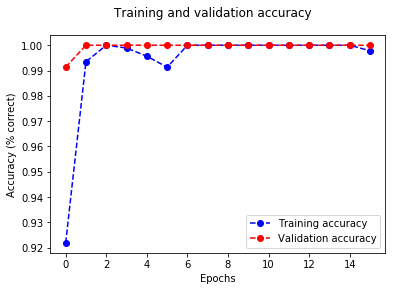

In [30]:
fig = bn.plot_accuracy(training)

In [ ]:
#p = model.predict(data_test, batch_size=5)

In [ ]:
#p_idx = np.argmax(p, axis=-1)
#labels_test_idx = np.argmax(labels_test, axis=-1)

In [ ]:
#bn.print_accuarcystats(p_idx,labels_test_idx)

In [ ]:
#bn.plotconfusionmat(bundle_names, p_idx, labels_test_idx)

Cross-predict on *another subject*

In [31]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [32]:
streamlines_all = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 

In [33]:
map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
map_file_index = []
labels_subj2 = []
for m_idx, m in enumerate(map_files):
    tmp = np.load(m)
    map_file_index = np.append(map_file_index,tmp)
    labels_subj2 = np.append(labels_subj2,m_idx*np.ones([len(tmp),1]))
labels_subj2

array([ 0.,  0.,  0., ..., 15., 15., 15.])

In [34]:
ind = range(len(streamlines_all))
ind = np.delete(ind,map_file_index)
np.random.shuffle(ind)
unlabeled_streamlines = ind[0:len(map_file_index)]
labels_subj2 = np.append(labels_subj2,16*np.ones([len(map_file_index),1]))

In [36]:
np.append(map_file_index,unlabeled_streamlines)

array([186748., 199724., 199806., ..., 123706.,  99484.,  66899.])

In [37]:
streamlines_all_sub = [streamlines_all[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]
len(streamlines_all_sub)
len(labels_subj2)

57386

In [38]:
import imp  
imp.reload(bn)
streamlines_all_processed = bn.process_sl(streamlines_all_sub,-1,vol_shape_subj2,size_slimage,5)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [41]:
p_subj2 = model.predict(streamlines_all_processed, batch_size=5)

In [42]:
p_idx = np.argmax(p_subj2, axis=-1)
max(p_idx)

15

In [43]:
bn.print_accuarcystats(p_idx[labels_subj2<16],labels_subj2[labels_subj2<16])

Percent correct is 0.9882201233750392 
Kappa is: 0.9857376096410797
Jaccard is: 0.9882201233750392


In [80]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 17}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
X_train, X_test, y_train, y_test = train_test_split(p_subj2, labels_subj2, test_size=0.2, random_state=42, stratify=labels_subj2)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
p = np.argmax(preds,axis=1)

(array([9.000e+00, 5.000e+00, 7.000e+01, 3.100e+01, 5.400e+01, 4.000e+00,
        3.000e+00, 1.400e+01, 9.000e+00, 2.000e+00, 1.000e+00, 5.000e+00,
        5.000e+00, 3.500e+01, 3.000e+00, 5.000e+00, 5.484e+03]),
 array([ 0.        ,  0.94117647,  1.88235294,  2.82352941,  3.76470588,
         4.70588235,  5.64705882,  6.58823529,  7.52941176,  8.47058824,
         9.41176471, 10.35294118, 11.29411765, 12.23529412, 13.17647059,
        14.11764706, 15.05882353, 16.        ]),
 <a list of 17 Patch objects>)

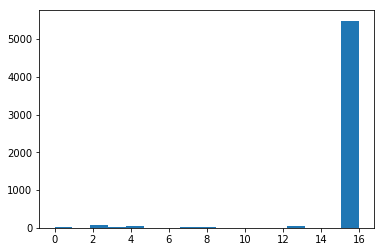

In [77]:
ind=y_test==16
plt.hist(p[ind],bins=17)

In [81]:
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = y_test == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p[ind]==i)/np.sum(ind)
    

In [79]:
perc_correct

array([[0.99016393],
       [0.95121951],
       [0.99043785],
       [0.99800797],
       [0.99773499],
       [0.9980198 ],
       [0.98051948],
       [0.8828125 ],
       [0.93023256],
       [0.86666667],
       [0.88888889],
       [0.96363636],
       [0.97378277],
       [0.69142857],
       [1.        ],
       [0.94444444],
       [0.95556717]])

In [73]:
nsl

array([[ 305.],
       [  82.],
       [1987.],
       [ 502.],
       [ 883.],
       [ 505.],
       [ 462.],
       [ 128.],
       [ 129.],
       [  15.],
       [  27.],
       [ 220.],
       [ 267.],
       [ 175.],
       [  34.],
       [  18.],
       [5739.]])